In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy 

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

##  GPs with Compact Support 

$k_{CS}(x, y) = bump(x) \times k_{rbf}(x, y) \times bump(y)$

In [27]:
def halfBump(x):
    e = np.piecewise(x, [x < 0, x >= 0], [lambda x: 0, lambda x: np.exp(-1/x)])
    return(e)

def bump(x, s):
    z = x**s
    f = halfBump(z) / (halfBump(z) + halfBump(1 - z))
    return(1 - f)

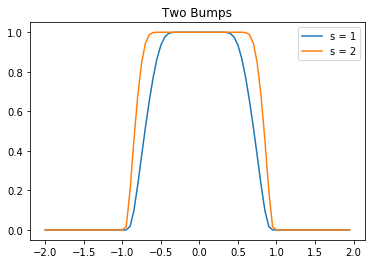

In [28]:
x = np.arange(-2, 2, 0.05)
y1 = bump(x, 2)
y2 = bump(x, 4)

plt.plot(x, y1, label = 's = 1')
plt.plot(x, y2, label = 's = 2')
plt.legend()
plt.title('Two Bumps')
plt.show()

In [29]:
xCol = x[:, None]
krbf = GPy.kern.RBF(1) 
Krbf = krbf.K(xCol, xCol)

In [30]:
npts = x.shape[0]
Kbump = np.zeros((npts, npts))

for i, a in enumerate(x):
    for j, b in enumerate(x): 
        Kbump[i, j] = bump(a, 2)*bump(b, 2)

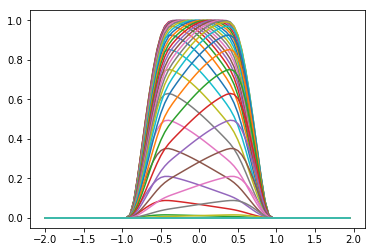

In [31]:
K = np.multiply(Krbf, Kbump)

for i in range(npts):
    plt.plot(x, K[i, :])
    
plt.show()

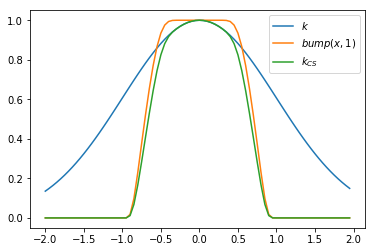

In [32]:
plt.plot(x, Krbf[40, :], label = '$k$')
plt.plot(x, y1, label = '$bump(x, 1)$')
plt.plot(x, K[40, :], label = '$k_{CS}$')
plt.legend()
plt.show()

 C:\Users\Personal\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning:Casting complex values to real discards the imaginary part


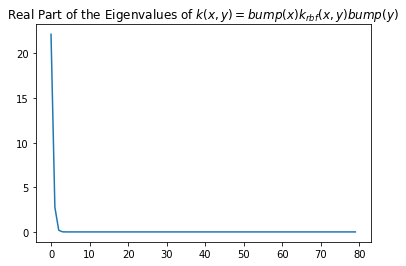

In [33]:
plt.plot(np.linalg.eig(K)[0])
plt.title('Real Part of the Eigenvalues of $k(x, y) = bump(x) k_{rbf}(x, y)  bump(y)$')
plt.show()

In [34]:
nsamples = 10
mu = np.zeros((npts)) 
Z = np.random.multivariate_normal(mu, K, nsamples)

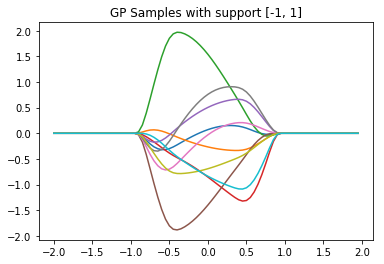

In [35]:
for i in range(nsamples):
    plt.plot(x[:], Z[i,:])
    
plt.title('GP Samples with support [-1, 1]')
plt.show()

### 2d bumps 

In [36]:
npts = 20
x = np.linspace(-1.2, 1.2, npts)
X = []
Bump2d = []
Kbump = np.zeros((npts, npts))

for i in range(npts):
    for j in range(npts):
        X.append([x[i], x[j]])
        Bump2d.append(bump(x[i], 2)*bump(x[j], 2))

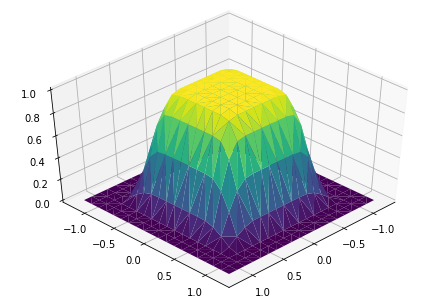

In [37]:
Bump2d = np.array(Bump2d)
X = np.array(X)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(X[:,0], X[:,1], Bump2d, cmap=cm.viridis)
ax.view_init(45, 45)
plt.show()

In [38]:
krbf2d = GPy.kern.RBF(2, lengthscale = 0.25)
Krbf2d = krbf2d.K(X, X)

In [14]:
npts = X.shape[0]
Kbump = np.zeros((npts, npts))

for i, x in enumerate(X):
    for j, y in enumerate(X):
        #print(i, j)
        Kbump[i, j] = bump(x[0], 2)*bump(x[1], 2) * bump(y[0], 2)*bump(y[1], 2) 

In [15]:
K2d = np.multiply(Kbump, Krbf2d)
mu = np.zeros((npts)) 
Zcs2d = np.random.multivariate_normal(mu, K2d, 1)
Zcs2d = Zcs2d.reshape(npts)

In [16]:
print(Zcs2d.shape, X[:,0].shape)

(400,) (400,)


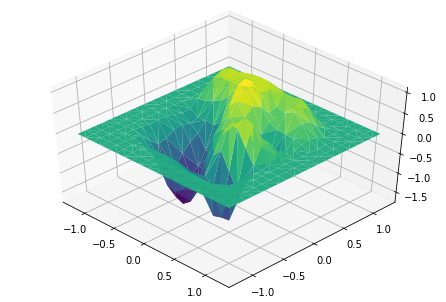

In [17]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(X[:,0], X[:,1], Zcs2d, cmap=cm.viridis)
ax.view_init(45, -45)
plt.show()

## Changepoint kernels

$k_{CP}(x, y) = \sigma(x) \times k(x, y) \times \sigma(y) + (1 - \sigma(x)) \times k(x, y) \times (1 - \sigma(y))$

In [48]:
def sigmoid(x, a):
    return(1 / (1 + np.exp(-a*x)))

In [50]:
kexp = GPy.kern.Exponential(1)

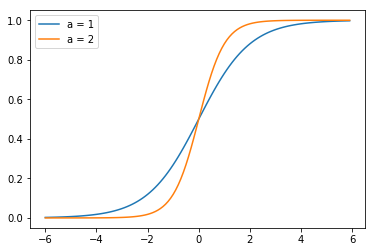

In [95]:
x = np.arange(-6, 6, 0.1)
y1 = sigmoid(x, 1)
y2 = sigmoid(x, 2)

plt.plot(x, y1, label = 'a = 1')
plt.plot(x, y2, label = 'a = 2')
plt.legend()
plt.show()

In [96]:
xvect = x[:, None]
npts = xvect.shape[0]

Kexp = kexp.K(xvect, xvect)
Krbf = krbf.K(xvect, xvect)
Ksig = np.zeros((npts, npts))
KsigI = np.zeros((npts, npts))

for i, x in enumerate(xvect):
    for j, y in enumerate(xvect):
        Ksig[i, j] = sigmoid(x, 1) * sigmoid(y, 1)
        KsigI[i, j] = (1 - sigmoid(x, 1)) * (1 - sigmoid(y, 1))

In [97]:
Kcp = np.multiply(Ksig, Krbf) + np.multiply(KsigI, Kexp)
Kcp.shape

(120, 120)

In [98]:
nsims = 10
mu = np.zeros(npts)
Zcp = np.random.multivariate_normal(mu, Kcp, nsims)

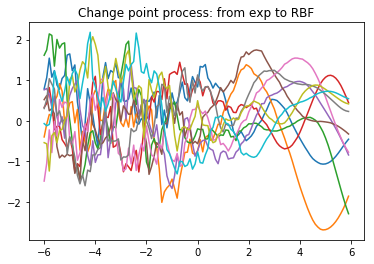

In [101]:
for i in range(nsims):
    plt.plot(xvect[:], Zcp[i,:])

    
plt.title('Change point process: from exp to RBF')
plt.show()